In [2]:
import json
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

## Reading in Chainlink Raw Data

In [3]:
file_path = "../chainlink_crypto_prices_2025-10-29.jsonl"
json_df = pd.read_json(path_or_buf=file_path, lines=True)
expanded_payload = pd.json_normalize(json_df['payload'])
expanded_payload = expanded_payload.rename(columns={'timestamp': "unix_timestamp"})
cl_df = pd.concat([json_df.drop('payload', axis=1), expanded_payload], axis=1)

In [4]:
cl_df

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.916,crypto_prices_chainlink,update,2616504000000000000,xrp/usd,1761765904000,2.616504
1,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.946,crypto_prices_chainlink,update,110941221874000000000000,btc/usd,1761765904000,110941.221874
2,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.887,crypto_prices_chainlink,update,3930641486000000000000,eth/usd,1761765904000,3930.641486
3,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.918,crypto_prices_chainlink,update,193980000000000000000,sol/usd,1761765904000,193.980000
4,TOWCmeuoLPECIJQ=,2025-10-29 19:25:06.182,crypto_prices_chainlink,update,110922179873228090000000,btc/usd,1761765905000,110922.179873
...,...,...,...,...,...,...,...,...
5204,TOWCmeuoLPECIJQ=,2025-10-29 19:46:56.113,crypto_prices_chainlink,update,3903690000000000000000,eth/usd,1761767215000,3903.690000
5205,TOWCmeuoLPECIJQ=,2025-10-29 19:46:57.084,crypto_prices_chainlink,update,3903787700000000000000,eth/usd,1761767216000,3903.787700
5206,TOWCmeuoLPECIJQ=,2025-10-29 19:46:57.086,crypto_prices_chainlink,update,110490226498553785000000,btc/usd,1761767216000,110490.226499
5207,TOWCmeuoLPECIJQ=,2025-10-29 19:46:57.081,crypto_prices_chainlink,update,192553930000000000000,sol/usd,1761767216000,192.553930


In [159]:
def chainlink_raw_to_pandas(file_path):
    json_df = pd.read_json(path_or_buf=file_path, lines=True)
    expanded_payload = pd.json_normalize(json_df['payload'])
    expanded_payload = expanded_payload.rename(columns={'timestamp': "unix_timestamp"})
    cl_df = pd.concat([json_df.drop('payload', axis=1), expanded_payload], axis=1)
    return cl_df

In [38]:
cl_df.dtypes

connection_id                  object
timestamp              datetime64[ns]
topic                          object
type                           object
full_accuracy_value            object
symbol                         object
unix_timestamp                  int64
value                         float64
dtype: object

In [39]:
cl_df.head()

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.916,crypto_prices_chainlink,update,2616504000000000000,xrp/usd,1761765904000,2.616504
1,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.946,crypto_prices_chainlink,update,110941221874000000000000,btc/usd,1761765904000,110941.221874
2,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.887,crypto_prices_chainlink,update,3930641486000000000000,eth/usd,1761765904000,3930.641486
3,TOWCmeuoLPECIJQ=,2025-10-29 19:25:04.918,crypto_prices_chainlink,update,193980000000000000000,sol/usd,1761765904000,193.980000
4,TOWCmeuoLPECIJQ=,2025-10-29 19:25:06.182,crypto_prices_chainlink,update,110922179873228090000000,btc/usd,1761765905000,110922.179873


In [122]:
cl_btc = cl_df[cl_df['symbol'] == 'btc/usd']
cl_btc['returns'] = np.log(cl_btc['value']).diff().dropna()

<Axes: xlabel='timestamp'>

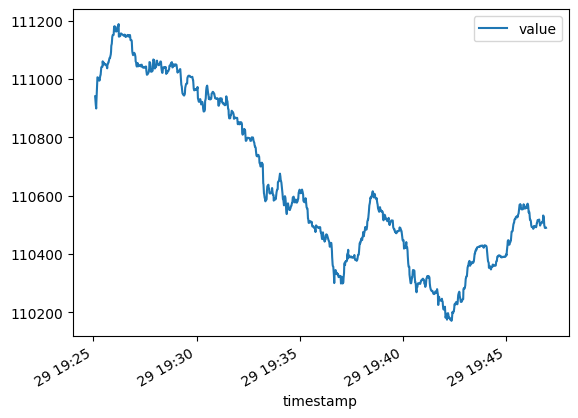

In [41]:
cl_btc.plot(kind = "line", x='timestamp', y='value')

In [123]:
def compute_vol(returns, effective_memory):
    # effective_memory = 1/(1-var_lambda)
    var_lambda = 1-1/effective_memory
    ewm_var = returns.ewm(alpha = (1-var_lambda)).var(bias=True)
    secs_in_year = 3.154e+7
    vol = np.sqrt(ewm_var) * np.sqrt(secs_in_year)
    return vol

cl_btc['vol'] = compute_vol(cl_btc['returns'], effective_memory=300)

<Axes: >

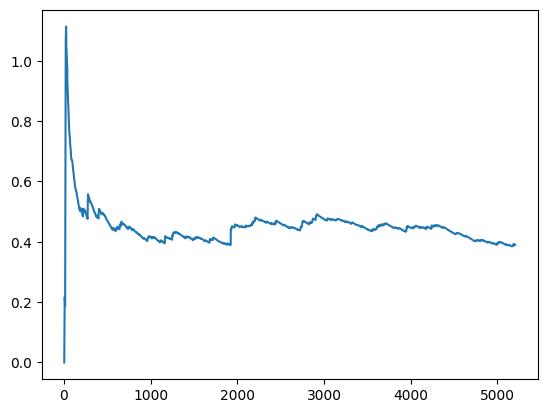

In [125]:
cl_btc['vol'].plot()

<Axes: >

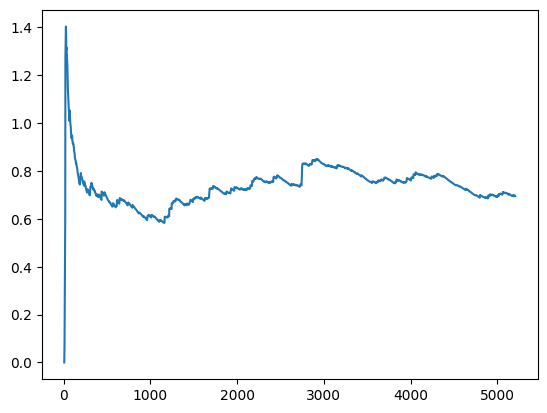

In [133]:
cl_eth = cl_df[cl_df['symbol'] == 'eth/usd']
cl_eth['returns'] = np.log(cl_eth['value']).diff().dropna()
cl_eth['vol'] = compute_vol(cl_eth['returns'], effective_memory=300)
cl_eth['vol'].plot()

<Axes: >

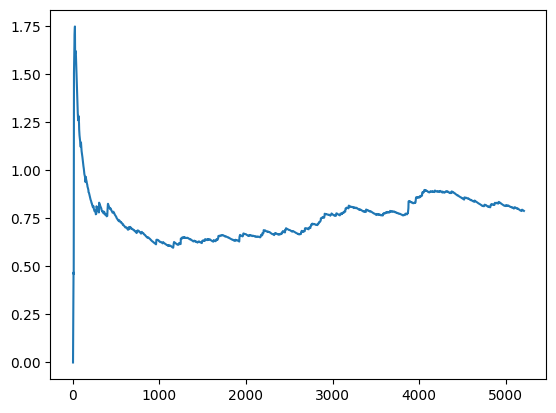

In [132]:
cl_xrp = cl_df[cl_df['symbol'] == 'xrp/usd']
cl_xrp['returns'] = np.log(cl_xrp['value']).diff().dropna()
cl_xrp['vol'] = compute_vol(cl_xrp['returns'], effective_memory=300)
cl_xrp['vol'].plot()

<Axes: >

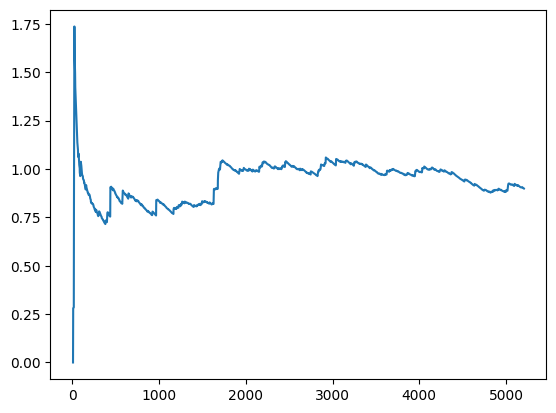

In [134]:
cl_sol = cl_df[cl_df['symbol'] == 'sol/usd']
cl_sol['returns'] = np.log(cl_sol['value']).diff().dropna()
cl_sol['vol'] = compute_vol(cl_sol['returns'], effective_memory=300)
cl_sol['vol'].plot()

### Reading Binance Raw Data

In [136]:
file_path = "../binance_crypto_prices_2025-10-29.jsonl"
binance_json_df = pd.read_json(file_path, lines=True)

In [137]:
binance_json_df.head()

,connection_id,payload,timestamp,topic,type
0,TOWCmcf1LPECGcQ=,"{'full_accuracy_value': '2.61450000', 'symbol'...",2025-10-29 19:25:06.179,crypto_prices,update
1,TOWCmcf1LPECGcQ=,"{'full_accuracy_value': '3929.01000000', 'symb...",2025-10-29 19:25:06.177,crypto_prices,update
2,TOWCmcf1LPECGcQ=,"{'full_accuracy_value': '110872.64000000', 'sy...",2025-10-29 19:25:06.147,crypto_prices,update
3,TOWCmcf1LPECGcQ=,"{'full_accuracy_value': '193.85000000', 'symbo...",2025-10-29 19:25:06.220,crypto_prices,update
4,TOWCmcf1LPECGcQ=,"{'full_accuracy_value': '3929.92000000', 'symb...",2025-10-29 19:25:07.148,crypto_prices,update


In [139]:
binance_payload_df = pd.json_normalize(binance_json_df['payload'])
binance_payload_df = binance_payload_df.rename(columns={"timestamp": "unix_timestamp"})
binance_df = pd.concat([binance_json_df.drop("payload", axis=1), binance_payload_df], axis=1)

In [140]:
binance_df

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TOWCmcf1LPECGcQ=,2025-10-29 19:25:06.179,crypto_prices,update,2.61450000,xrpusdt,1761765906000,2.6145
1,TOWCmcf1LPECGcQ=,2025-10-29 19:25:06.177,crypto_prices,update,3929.01000000,ethusdt,1761765906000,3929.0100
2,TOWCmcf1LPECGcQ=,2025-10-29 19:25:06.147,crypto_prices,update,110872.64000000,btcusdt,1761765906000,110872.6400
3,TOWCmcf1LPECGcQ=,2025-10-29 19:25:06.220,crypto_prices,update,193.85000000,solusdt,1761765906000,193.8500
4,TOWCmcf1LPECGcQ=,2025-10-29 19:25:07.148,crypto_prices,update,3929.92000000,ethusdt,1761765907000,3929.9200
...,...,...,...,...,...,...,...,...
5242,TOWCmcf1LPECGcQ=,2025-10-29 19:46:56.171,crypto_prices,update,2.58100000,xrpusdt,1761767216000,2.5810
5243,TOWCmcf1LPECGcQ=,2025-10-29 19:46:56.224,crypto_prices,update,192.50000000,solusdt,1761767216000,192.5000
5244,TOWCmcf1LPECGcQ=,2025-10-29 19:46:57.167,crypto_prices,update,3903.11000000,ethusdt,1761767217000,3903.1100
5245,TOWCmcf1LPECGcQ=,2025-10-29 19:46:57.196,crypto_prices,update,110472.34000000,btcusdt,1761767217000,110472.3400


In [141]:
binance_btc = binance_df[binance_df['symbol'] == 'btcusdt']

In [145]:
binance_btc.dtypes

connection_id                  object
timestamp              datetime64[ns]
topic                          object
type                           object
full_accuracy_value            object
symbol                         object
unix_timestamp                  int64
value                         float64
returns                       float64
dtype: object

In [146]:
binance_btc['returns'] = np.log(binance_btc['value']).diff().dropna()
binance_btc['vol'] = compute_vol(binance_btc['returns'], effective_memory=300)

<Axes: >

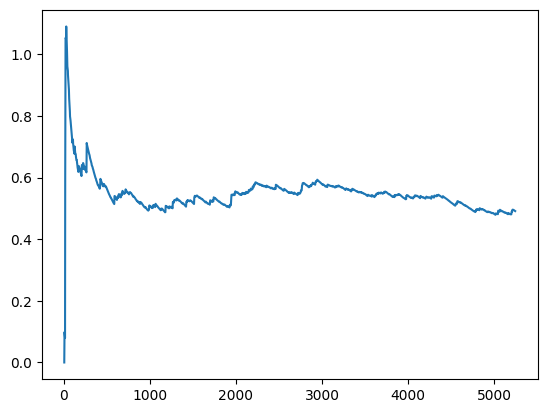

In [147]:
binance_btc['vol'].plot()

## Comparing Chainlink and Binance Pricing for Bitcoin

#### Binance is much more volatile

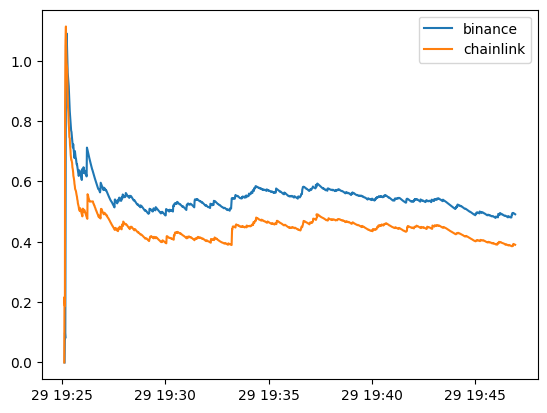

In [151]:
import matplotlib.pyplot as plt

plt.plot(binance_btc['timestamp'], binance_btc['vol'], label="binance")
plt.plot(cl_btc['timestamp'], cl_btc['vol'], label="chainlink")
plt.legend()

#### Chainlink almost always has a higher marked price

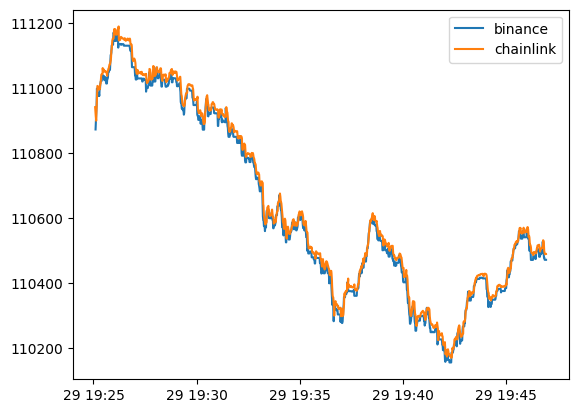

In [153]:
plt.plot(binance_btc['timestamp'], binance_btc['value'], label="binance")
plt.plot(cl_btc['timestamp'], cl_btc['value'], label="chainlink")
plt.legend()

In [158]:
merged = pd.merge(binance_btc, cl_btc, on='unix_timestamp')
len(merged[merged['value_x'] > merged['value_y']]), len(merged)
np.mean(merged['value_x'] - merged['value_y']) #

np.float64(-15.096109557785574)

In [152]:
len(binance_btc), len(cl_btc)

(1312, 1302)